In [1]:
import yfinance as yf
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [2]:
data = yf.Ticker("AAPL")
data = data.history(period="max")
data = data.loc["2008-01-01":].copy()
data = data.loc[:, data.columns.intersection(['Close'])]
data

,Close
Date,
2008-01-02 00:00:00-05:00,5.876343
2008-01-03 00:00:00-05:00,5.879056
2008-01-04 00:00:00-05:00,5.430279
2008-01-07 00:00:00-05:00,5.357592
2008-01-08 00:00:00-05:00,5.164871
...,...
2024-10-04 00:00:00-04:00,226.800003
2024-10-07 00:00:00-04:00,221.690002
2024-10-08 00:00:00-04:00,225.770004


<Axes: xlabel='Date'>

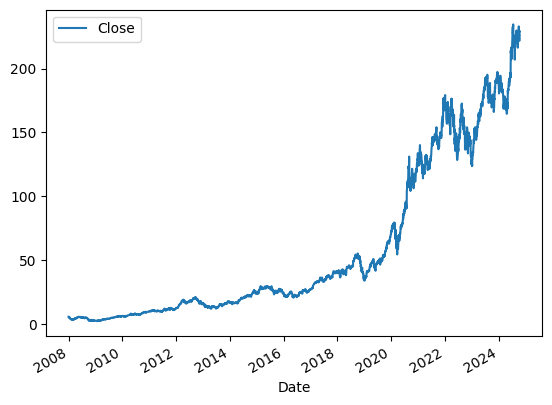

In [3]:
data.plot.line(y="Close", use_index=True)

In [4]:
len(data)

4223

In [5]:
train = data[["Close"]].iloc[:4181]
test = data[["Close"]].iloc[4181:]

I got the below code segment from: https://www.analyticsvidhya.com/blog/2018/09/an-introduction-to-non-stationary-time-series-in-python/. It runs a statistical test on the data to see if it is non-stationary or stationary. I later realized I didn't need to test for this but I still wanted to keep it in for this version of the model.

In [6]:
# #define function for ADF test
# from statsmodels.tsa.stattools import adfuller
# def adf_test(timeseries):
#     #Perform Dickey-Fuller test:
#     print ('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#        dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)

# #apply adf test on the series
# adf_test(train)
# adf_test(test)
# adf_test(data)

In [7]:
scaler = StandardScaler()
scaler.fit(data)
train = scaler.transform(train)
test = scaler.transform(test)
train

array([[-0.83627309],
       [-0.83622945],
       [-0.84345024],
       ...,
       [ 2.49735769],
       [ 2.54444689],
       [ 2.56922532]])

In [8]:
length = 30
batch_size = 1

generator = TimeseriesGenerator(train, train, length=length, batch_size=batch_size)
X, y = generator[0]
X
X.shape

(1, 30, 1)

In [9]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, batch_size)))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

C:\Users\varun\anaconda3\envs\stock_pred\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.fit(generator,epochs=5)

Epoch 1/5
  20/4151 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.3495 

C:\Users\varun\anaconda3\envs\stock_pred\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4151/4151 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 0.0417
Epoch 2/5
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.0091
Epoch 3/5
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 0.0062
Epoch 4/5
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.0047
Epoch 5/5
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 0.0045


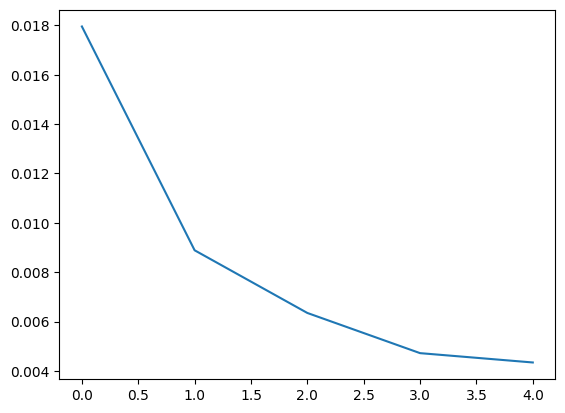

In [11]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [12]:
predictions = []

first_batch = train[-length:]
current_batch = first_batch.reshape((1, length, batch_size))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

In [13]:
predictions

[array([2.5618038], dtype=float32),
 array([2.5700488], dtype=float32),
 array([2.5788631], dtype=float32),
 array([2.5874429], dtype=float32),
 array([2.595778], dtype=float32),
 array([2.6038768], dtype=float32),
 array([2.6117523], dtype=float32),
 array([2.6194174], dtype=float32),
 array([2.6268845], dtype=float32),
 array([2.6341624], dtype=float32),
 array([2.6412597], dtype=float32),
 array([2.6481833], dtype=float32),
 array([2.65494], dtype=float32),
 array([2.6615343], dtype=float32),
 array([2.6679711], dtype=float32),
 array([2.6742554], dtype=float32),
 array([2.6803916], dtype=float32),
 array([2.6863835], dtype=float32),
 array([2.6922352], dtype=float32),
 array([2.6979506], dtype=float32),
 array([2.703533], dtype=float32),
 array([2.7090023], dtype=float32),
 array([2.7143793], dtype=float32),
 array([2.7196648], dtype=float32),
 array([2.7248597], dtype=float32),
 array([2.7299645], dtype=float32),
 array([2.7349799], dtype=float32),
 array([2.7399075], dtype=float3

In [14]:
test = pd.DataFrame(test)
test['Predictions'] = predictions

In [15]:
test = scaler.inverse_transform(test)

In [16]:
test = pd.DataFrame(test)
test

,0,1
0,221.270004,217.068748
1,221.720001,217.581179
2,224.720001,218.128995
3,226.050003,218.662230
4,225.889999,219.180262
5,226.509995,219.683610
6,226.399994,220.173073
7,224.529999,220.649467
8,226.839996,221.113547
9,227.179993,221.565877


<Axes: >

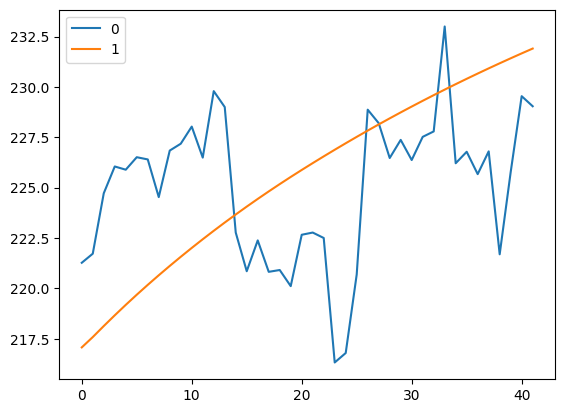

In [17]:
test.plot()

In [18]:
rmse = sqrt(mean_squared_error(test[0],test[1]))
rmse

5.106936155579168

In [19]:
mae = mean_absolute_error(test[0], test[1])
mae

4.4999521161483